In [42]:
%matplotlib inline
# Core
import numpy as np
import cv2
import io
from skimage.measure import label, regionprops
from imageio import imwrite
import statistics as stats
import math
import sys

# Visualization
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

# File Chooser
import tkinter as tk
from tkinter import filedialog

In [4]:
# Settings & Globals
printText = False

kernel = np.ones((3, 3), np.uint8)

In [5]:
# Get Image
def getImage(file_path="", blockSize=505, C=-2):
    root = tk.Tk()
    root.withdraw()
    if file_path == "":
        file_path = filedialog.askopenfilename(filetypes=[("Image Files", ".png .jpg")])
    src_img = cv2.imread(file_path)
    copy = src_img.copy()
    copy[:, :, 1] = copy[:, :, 2] = 0
    gray = cv2.cvtColor(copy, cv2.COLOR_BGR2GRAY)
    gray = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize, C
    )  ########## 2 magic numbers here
    return gray

In [6]:
# Noise Removal
def noiseRemoval(gray, openIter=3, closeIter=3):
    clean = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel, iterations=openIter)
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel, iterations=closeIter)
    return clean

In [7]:
# Get Coverage
def getCoverage(clean):
    coverage = np.count_nonzero(clean) / (clean.shape[0] * clean.shape[1])
    if printText:
        print(str(coverage) + "%")
    return coverage

In [8]:
# copied from JUN_NETWORKS at https://stackoverflow.com/questions/7821518/matplotlib-save-plot-to-numpy-array
def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=180)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

In [9]:
# Get Regions
def getRegions(sourceImage,clean, blockSize=403, C=-4, minArea=0.00025, boxColor="red"):
    sure_bg = cv2.dilate(clean, kernel, iterations=1)
    dist_transform = cv2.distanceTransform(sure_bg, cv2.DIST_L2, 0)
    dist_transform = np.uint8(dist_transform)
    dt_fg = cv2.adaptiveThreshold(
        dist_transform, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blockSize, C
    )
    unknown = cv2.subtract(sure_bg, dt_fg)
    ret, markers = cv2.connectedComponents(dt_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    shedded = cv2.watershed(sourceImage, markers)
    edge = markers == -1
    edge = cv2.dilate(edge.astype(np.uint8), kernel)

    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(sourceImage)

    label_image = label(markers)
    region_count = 0
    height = label_image.shape[1]
    width = label_image.shape[0]
    for region in regionprops(label_image):
        if region.area >= (minArea * height * width):  # Aribtuary
            region_count += 1
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle(
                (minc, minr),
                maxc - minc,
                maxr - minr,
                fill=False,
                edgecolor=boxColor,
                linewidth=1,
            )
            ax.add_patch(rect)

    regionsFound=get_img_from_fig(plt)

    if printText:
        print(region_count)

    return region_count, regionsFound

In [10]:
def processImage(
    file_path="",
    blockSize1=505,
    C1=-2,
    blockSize2=403,
    openIter=3,
    closeIter=3,
    C2=-4,
    minArea=0.00025,
    boxColor="red",
):
    sourceImage = cv2.imread(file_path)
    sourceImage = cv2.cvtColor(sourceImage, cv2.COLOR_BGR2RGB)
    gray = getImage(file_path, blockSize1, C1)
    clean = noiseRemoval(gray, openIter, closeIter)
    coverage = getCoverage(clean)
    regionCount, regionsFound = getRegions(
        sourceImage, clean, blockSize2, C2, minArea, boxColor
    )
    return coverage, regionCount, regionsFound

In [11]:
def _init_():
    return

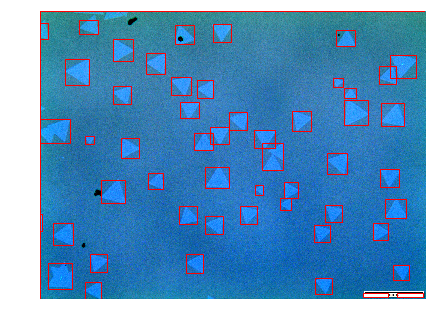

In [12]:
a, b, c = processImage("dummy.jpg")

In [13]:
def truncate_image(image,y_front=0,y_back=40,x_front=0,x_back=0,save=False,name=""):
    height,width=image.shape[:2]
    print(image.shape)
    if(len(image.shape)==2):
        image=image[y_front:height-y_back-1,x_front:width-x_back-1]
    else:
        image=image[y_front:height-y_back-1,x_front:width-x_back-1,:]
    if(save):
        if(name==""):
            name="truncated_image.png"
        imwrite(name,image)
    return image


def find_regions(sourceImage,clean, blockSize=403, C=-4, minArea=0.00025):
    sure_bg = cv2.dilate(clean, kernel, iterations=1)
    dist_transform = cv2.distanceTransform(sure_bg, cv2.DIST_L2, 0)
    dist_transform = np.uint8(dist_transform)
    dt_fg = cv2.adaptiveThreshold(
        dist_transform, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blockSize, C
    )
    unknown = cv2.subtract(sure_bg, dt_fg)
    ret, markers = cv2.connectedComponents(dt_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    shedded = cv2.watershed(sourceImage, markers)
    edge = markers == -1
    edge = cv2.dilate(edge.astype(np.uint8), kernel)

    label_image = label(markers)
    height = label_image.shape[1]
    width = label_image.shape[0]
    regions=[]
    ## https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops
    for region in regionprops(label_image):
        if region.area >= (minArea * height * width):
            bbox=region.bbox
            r_height,r_width=bbox[2]-bbox[0],bbox[3]-bbox[1]
            ratio=r_height/r_width
            if(ratio>1):
                ratio=1/ratio
            if(ratio>0.7): ## height of equilateral triangle is 0.86, give some buffer so 0.7
                regions.append(region)
    return regions[2:] ## first 2 are origin and entire image, both reject

(1532, 2048, 3)
47 7


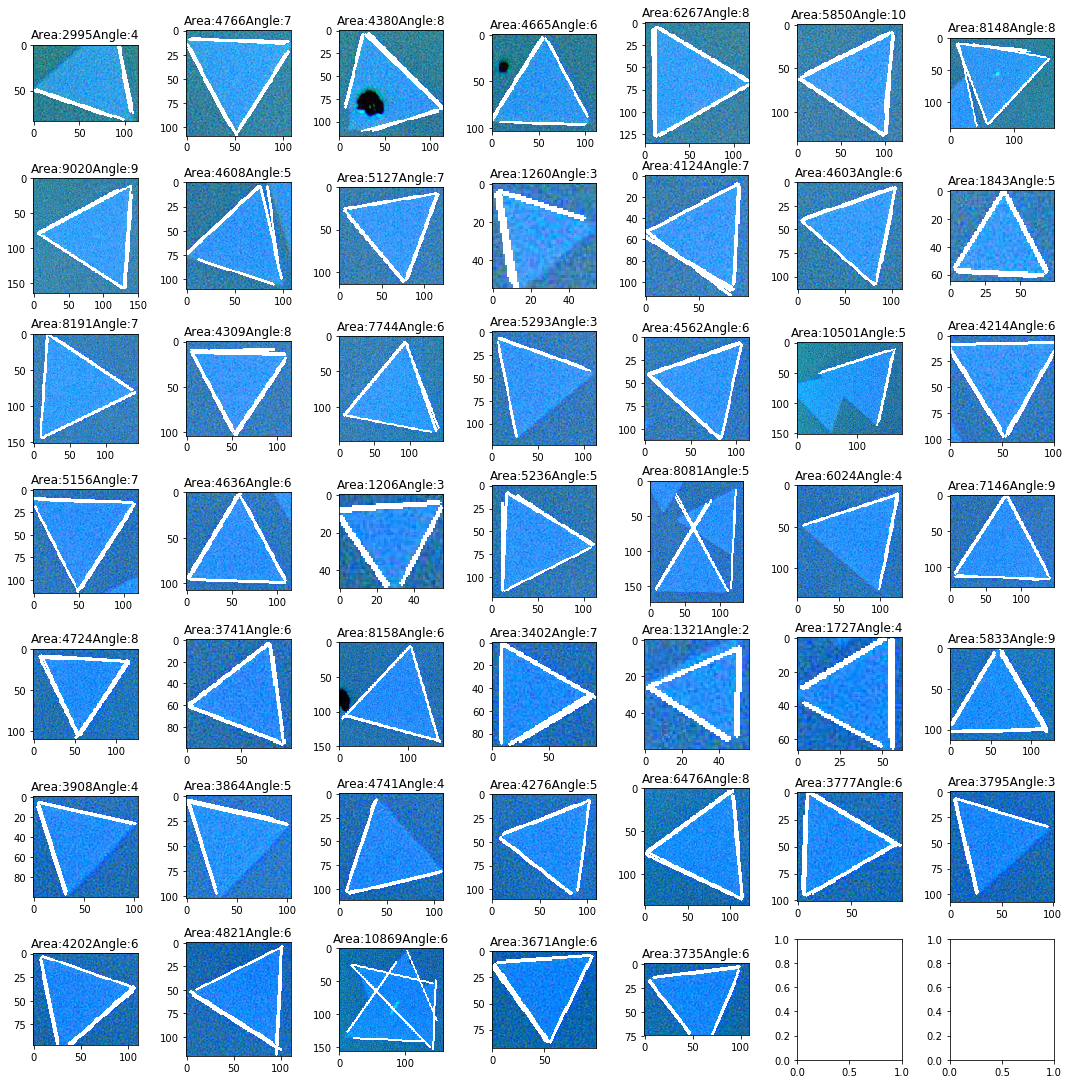

In [14]:
def get_parameters_from_region(source,region):
    #return region.convex_image,1
    bbox=region.bbox
    height=bbox[2]-bbox[0]
    width=bbox[3]-bbox[1]
    ## Widen 20% on actual image to make getting lines more accurate(some lines lay on the bbox)
    source_height,source_width=source.shape[0],source.shape[1]
    y_offset=height//10
    x_offset=width//10
    miny,minx,maxy,maxx=bbox[0]-y_offset,bbox[1]-x_offset,bbox[2]+y_offset,bbox[3]+x_offset
    height+=2*y_offset
    width+=2*x_offset
    if(miny<0):
        miny=0
        height-=y_offset
    if(minx<0):
        minx=0
        width-=x_offset
    if(maxy>=source_height):
        maxy=source_height-1
        height-=y_offset
    if(maxx>=source_width):
        maxx=source_width-1
        width-=x_offset
    image=source[miny:maxy,minx:maxx,:]
    canvas=image.copy()
    gray=cv2.cvtColor(canvas,cv2.COLOR_RGB2GRAY)
    gray=cv2.GaussianBlur(gray,(3,3),1)
    edges = cv2.Canny(gray,50,100,apertureSize = 3)
    lines = cv2.HoughLinesP(edges,1,np.pi/180,20,minLineLength=2*height/3,maxLineGap=height/3)

    angles=[]
    
    if(lines is None):
        return edges,0

    for line in lines:
        points=line[0]
        x1,y1,x2,y2=points[0],points[1],points[2],points[3]
        cv2.line(canvas,(x1,y1),(x2,y2),(255,255,255),2)
        angles.append(get_rotation(x1,y1,x2,y2))
    if(len(lines)==2):
        line1=lines[0][0]
        line2=lines[1][0]
        x1_1,y1_1,x2_1,y2_1=line1[0],line1[1],line1[2],line1[3]
        x1_2,y1_2,x2_2,y2_2=line2[0],line2[1],line2[2],line2[3]
        pairs_of_points=[(x1_1,y1_1,x1_2,y1_2),(x2_1,y2_1,x1_2,y1_2),(x2_1,y2_1,x2_2,y2_2),(x1_1,y1_1,x2_2,y2_2)]
        distances=[]
        for i in range(4):
            points=pairs_of_points[i]
            dist=(points[2]-points[0])**2+(points[3]-points[1])**2
            distances.append(dist)
        to_draw=pairs_of_points[(distances.index(sorted(distances)[0])+2)%4]#Look at order in pairs_of_points
        cv2.line(canvas,(to_draw[0],to_draw[1]),(to_draw[2],to_draw[3]),(255,255,255),2)
        angles.append(get_rotation(to_draw[0],to_draw[1],to_draw[2],to_draw[3]))

    return canvas,len(lines)#float("{0:.2f}".format(stats.median(angles)))

def get_rotation(x1,y1,x2,y2):
    if(y2<y1):
        x1,y1,x2,y2=x2,y2,x1,y1
    o=(x2-x1)
    a=(y2-y1)
    if(x2<x1):
        const=-1
    return ((math.atan(o/a)*180/math.pi)+360)%120-30 ## 30 is upright


def min_square(count):
    side=1
    while(side**2<count):
        side+=1
    return side

un_trunc=cv2.imread("dummy.jpg")
un_trunc=cv2.cvtColor(un_trunc,cv2.COLOR_BGR2RGB)
truncate_image(un_trunc,save=True,name="trunc_dummy.jpg")
sourceImage = cv2.imread("trunc_dummy.jpg")
sourceImage = cv2.cvtColor(sourceImage, cv2.COLOR_BGR2RGB)
gray = getImage("trunc_dummy.jpg")
clean = noiseRemoval(gray)
regions=find_regions(sourceImage,clean)
side=min_square(len(regions))
print(len(regions),side)
fig,ax=plt.subplots(side,side,figsize=(15,15))
fig.tight_layout()
for i in range(len(regions)):
    region=regions[i]
    axis=ax[i//side][i%side]
    #axis.imshow(region.image)
    image,lines=get_parameters_from_region(sourceImage,region)
    axis.imshow(image)
    title="Area:"+str(region.area)+"Angle:"+str(lines)#+"Coords:"+','.join(str(e) for e in region.coords[0])
    axis.set_title(title)
    
# def find_angle_from_triangle():
#     """input: black and white image with just 1 triangle"""
    
def triangle_area(triangles):#list of regions
    area=0
    total=0
    for triangle in triangles:
        area+=triangle.convex_area
        total+=triangle.area
    return area,area/total



In [15]:
print(get_rotation(1,1,2,2))

15.0


In [69]:
## Copied from https://alyssaq.github.io/2014/understanding-hough-transform/
def hough_line(img):
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0))
    width, height = img.shape
    diag_len = int(np.ceil(np.sqrt(width * width + height * height)))   # max_dist
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2.0)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img)  # (row, col) indexes to edges

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = int(round(x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len)
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos

## Plot 4

(1532, 2048, 3)


C:\Users\65853\Anaconda3\envs\cv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


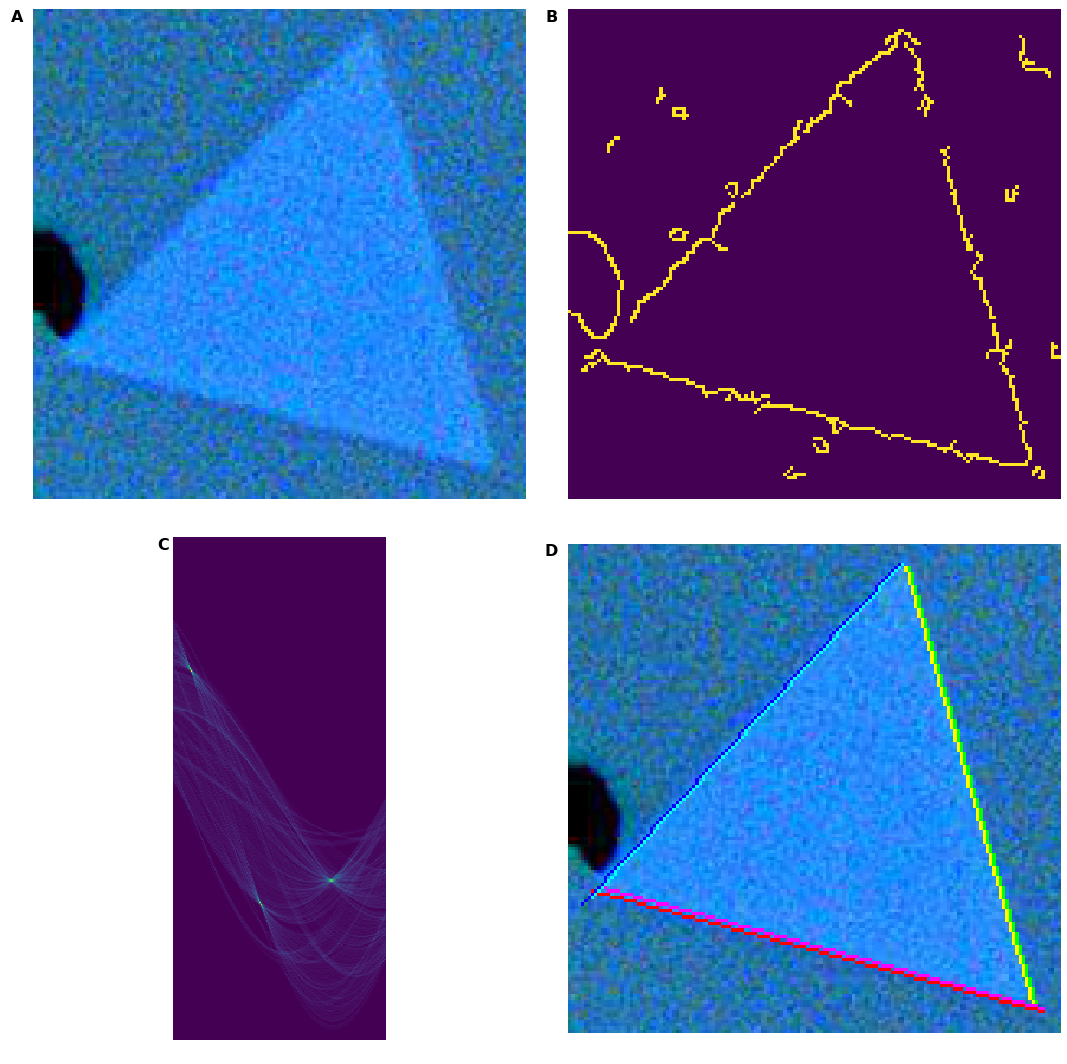

In [75]:
un_trunc=cv2.imread("dummy.jpg")
un_trunc=cv2.cvtColor(un_trunc,cv2.COLOR_BGR2RGB)

truncate_image(un_trunc,save=True,name="trunc_dummy.jpg")
source = cv2.imread("trunc_dummy.jpg")
source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)
gray = getImage("trunc_dummy.jpg")
clean = noiseRemoval(gray)
regions=find_regions(source,clean)
fig,ax=plt.subplots(2,2,figsize=(15,15))
fig.tight_layout()

region=regions[30]

bbox=region.bbox
height=bbox[2]-bbox[0]
width=bbox[3]-bbox[1]
source_height,source_width=source.shape[0],source.shape[1]
y_offset=height//10
x_offset=width//10
miny,minx,maxy,maxx=bbox[0]-y_offset,bbox[1]-x_offset,bbox[2]+y_offset,bbox[3]+x_offset
height+=2*y_offset
width+=2*x_offset
if(miny<0):
    miny=0
    height-=y_offset
if(minx<0):
    minx=0
    width-=x_offset
if(maxy>=source_height):
    maxy=source_height-1
    height-=y_offset
if(maxx>=source_width):
    maxx=source_width-1
    width-=x_offset
image=source[miny:maxy,minx:maxx,:]
ax[0][0].imshow(image)
canvas=image.copy()
gray=cv2.cvtColor(canvas,cv2.COLOR_RGB2GRAY)
gray=cv2.GaussianBlur(gray,(3,3),1)
edges = cv2.Canny(gray,50,100,apertureSize = 3)
ax[0][1].imshow(edges)
lines = cv2.HoughLinesP(edges,1,np.pi/180,20,minLineLength=2*height/3,maxLineGap=height/3)

accumulator, thetas, rhos = hough_line(edges)
ax[1][0].imshow(accumulator)

colors=[(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255),(255,255,255),(0,0,0)]
color_count=0
for line in lines:
    points=line[0]
    x1,y1,x2,y2=points[0],points[1],points[2],points[3]
    cv2.line(canvas,(x1,y1),(x2,y2),colors[color_count],1)
    color_count+=1
    
ax[1][1].imshow(canvas)

for i, abcd in enumerate(('A', 'B', 'C', 'D')):
    axis = ax[i//2][i%2]
    axis.text(-0.02,1, abcd, transform=axis.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
    axis.axis('off')
    
fig.savefig('4')

In [ ]:
v = 1+1
print(v)